In [1]:
from ChromoGen import Conformations
from ChromoGen.data_utils import HiCDataset, HiCMap
from ChromoGen.model.Diffuser.training_utils import ConfigDataset

import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import torch
import numpy as np
import pickle
from torcheval.metrics.functional import r2_score
from tqdm.auto import tqdm 
import os
import sys
from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm 

plt.style.use('../support/plot_style.txt')

2024-11-25 10:16:20.879923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Filepaths

In [2]:
gm_cgen_conformations_dir = '../../downloaded_data/conformations/ChromoGen/genome_wide/GM12878'
imr_cgen_conformations_dir = '../../downloaded_data/conformations/ChromoGen/genome_wide/IMR90'

gm_mcool_fp = '../../outside_data/hic/GM12878_hg19.mcool'
imr_mcool_fp = '../../outside_data/hic/IMR90_hg19.mcool'

temp_data_dir = './temp_data/'
pdf_dir = './pdfs/'

r_c = 1.5 
sigma = 3.72
decay_rate=3.45

resolution = 20_000

use_gpu = True
high_precision = False

max_workers = None

In [3]:
gm_cgen_conformations_dir = Path(gm_cgen_conformations_dir)
assert gm_cgen_conformations_dir.exists(), (
    'Need to download the genome-wide generated conformation data for GM12878 cells '
    '(or regenerate them yourself and change cgen_conformations_dir to that location).'
)
imr_cgen_conformations_dir = Path(imr_cgen_conformations_dir)
assert imr_cgen_conformations_dir.exists(), (
    'Need to download the genome-wide generated conformation data for IMR-90 cells '
    '(or regenerate them yourself and change cgen_conformations_dir to that location).'
)

gm_hic = HiCDataset(gm_mcool_fp, resolution=resolution)
imr_hic = HiCDataset(imr_mcool_fp, resolution=resolution)

r_c = float(r_c)
sigma = float(sigma)
decay_rate = float(decay_rate)

assert isinstance(use_gpu,bool)
use_gpu = use_gpu and torch.cuda.is_available()

assert isinstance(high_precision,bool)

assert isinstance(resolution,int) and resolution > 0

temp_data_dir = Path(temp_data_dir)
temp_data_dir.mkdir(exist_ok=True,parents=True)

pdf_dir = Path(pdf_dir)
pdf_dir.mkdir(exist_ok=True,parents=True)

## Analyze

#### Support functions

In [26]:
def load_region(chrom,start,dir_,guidance_params=[(1.,0.),(5.,8.)]):
    coords = []
    for cs,rp in guidance_params:
        coords.append(Conformations(
            dir_ / f'chrom_{chrom}/start_idx_{start//1000}_cond_scale_{cs}_rescaled_phi_{rp}.pt',
            drop_invalid_conformations=True
        ))

    return coords[0].cat(coords[1:])
    
    # ~5% of IMR files contain at least one conformation containing NaN values, so
    # make sure that there is, indeed, a 50-50 split between the guidance weights
    n = min(len(c) for c in coords)

    return coords[0][:n,...].cat([c[:n,...] for c in coords[1:]])
    

In [27]:
def compute_pcc(x,y,x_log=False, y_log=False,drop_nan=False):
    # x & y are either a Distances or HiCMap instance
    x = x.values.squeeze()
    y = y.values.squeeze()

    assert x.ndim==y.ndim==2, 'Should only pass one sample for x & y.'

    # Prepare for torch.corrcoef
    n = x.shape[-2]
    i,j = torch.triu_indices(n,n,1) # Ignore diagonal b/c it's all zeros (dists)/ones (probs)
    data = torch.stack(
        [
            x[i,j],
            y[i,j]
        ],
        dim=0
    )

    # Ignore NaN values
    if drop_nan:
        data = data[:, data.isfinite().all(0)]

    if data.shape[-1] == 0:
        return torch.nan

    # Take the log of neither, one, or both sets of data
    if x_log:
        if y_log:
            data.log_()
        else:
            data[0,:].log_()
    elif y_log:
        data[1,:].log_()

    # Compute & return the pearson correlation coefficient
    return torch.corrcoef(data)[0,1].cpu()

In [28]:
def full_pipeline(
    chrom,
    start,
    cgen_directory,
    hic_dataset,
    resolution=resolution,
    r_c=r_c,
    sigma=sigma,
    decay_rate=decay_rate,
    use_gpu=use_gpu,
    high_precision=high_precision
):
    ###
    # Preparation
    
    # Load
    coords = load_region(chrom,start,cgen_directory)
    n = coords.num_beads
    exp_hic = hic_dataset.fetch(chrom,start, start + resolution*n)

    if use_gpu:
        coords.cuda_()
    if high_precision:
        coords.double_()
    else:
        coords.float_()
        
    exp_hic.to_(dtype=coords.dtype,device=coords.device)

    # 
    # Get median distances & infer Hi-C maps
    med_dists = coords.distances.median
    cgen_hic = coords.compute_hic(r_c, sigma, decay_rate)

    ###
    # Correlation between:

    # Median distance & log probability
    # Hi-C maps contain NaN's in many regions, so ignore them
    # for a more complete picture
    dist_corr = compute_pcc(med_dists, exp_hic, False, True, True).cpu()
    #dist_corr = compute_pcc(med_dists, exp_hic, False, True, False).cpu()

    # Hi-C vs Hi-C 
    prob_v_prob = compute_pcc(cgen_hic, exp_hic, False, False, True).cpu()
    
    return dist_corr, prob_v_prob

#### Compute

In [29]:
save_fp = temp_data_dir / f'correlation_stats.pt'

if False:#save_fp.exists():
    results = torch.load(save_fp)

else:
    results = torch.load(save_fp)#{}
    
    for ct,cgen_dir, hic_dataset  in [
        ('GM12878',gm_cgen_conformations_dir,gm_hic),
        ('IMR-90',imr_cgen_conformations_dir,imr_hic)
    ]:
        results[ct] = {'dist':{},'hic':{}}
        files = list(cgen_dir.rglob('*1.0_rescaled_phi_0.0.pt'))
        files.sort()
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            
            for fp in files:
                chrom = fp.parent.name.split('_')[-1]
                start_idx = int(fp.name.split('_')[2]) * 1000
    
                #dist_corr, prob_v_prob = full_pipeline(chrom,start_idx,cgen_dir,hic_dataset)
                
                if chrom not in results[ct]['dist']:
                    results[ct]['dist'][chrom] = {}
                    results[ct]['hic'][chrom] = {}
    
                results[ct]['dist'][chrom][start_idx] = executor.submit(
                    full_pipeline,
                    chrom,
                    start_idx,
                    cgen_dir,
                    hic_dataset
                )

            for fp in tqdm(files, desc=ct):
                chrom = fp.parent.name.split('_')[-1]
                start_idx = int(fp.name.split('_')[2]) * 1000

                dist_corr, prob_v_prob = results[ct]['dist'][chrom][start_idx].result()
                results[ct]['dist'][chrom][start_idx] = dist_corr
                results[ct]['hic'][chrom][start_idx] = prob_v_prob
                
                

    torch.save(results,save_fp)


GM12878:   0%|          | 0/2658 [00:00<?, ?it/s]

IMR-90:   0%|          | 0/2658 [00:00<?, ?it/s]

## Plot

#### Support

In [ ]:
def plot_hist(
    data1,
    data2,
    tag1,
    tag2,
    nbins=25,
    fig=None,
    ax=None,
    alpha=0.5,
    bins=None
):

    # Convert to numpy to improve speed in plt 
    data1 = data1[data1.isfinite()].cpu().numpy()

    # Handle data2 not None vs None cases
    if data2 is None:
        if bins is None:
            minn = data1.min()
            maxx = data1.max()
    else:
        data2 = data2[data2.isfinite()].cpu().numpy()
        if bins is None:
            minn = min(data1.min(),data2.min())
            maxx = max(data1.max(),data2.max())

    # Create consistent bins for each data type
    if bins is None:
        delta = (maxx-minn)/nbins
        bins = np.arange(minn,maxx+delta/2,delta)

    # Create the figure, if necessary
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    # Create the histogram
    ax.hist(data1,alpha=alpha,bins=bins,label=tag1,edgecolor='none',density=True)
    if data2 is not None:
        ax.hist(data2,alpha=alpha,bins=bins,label=tag2,edgecolor='none',density=True)

    return fig, ax

#### Plot & save

In [ ]:
fig,axes = plt.subplots(ncols=2,nrows=1,layout='constrained',figsize=(3,1.75))


###########################
# Median dists vs log probabilities

####
# fetch data from the dictionaries
data1 = []
for chrom,data_dict in results['IMR-90']['dist'].items():
    if chrom == 'X':
        continue
    data1+= [v for v in data_dict.values()]
data2 = []
for chrom,data_dict in results['GM12878']['dist'].items():
    if chrom == 'X':
        continue
    data2+= [v for v in data_dict.values()]

data1 = torch.tensor(data1)
data2 = torch.tensor(data2)

####
# Plot
ax = axes[0]
#bins = torch.arange(-1,-.599,.4/15)
bins = torch.arange(-0.9756, -0.4105+.0003, (-0.4105+0.9756)/25)
plot_hist(
    data1 = data1,
    data2 = data2,
    tag1 = 'IMR-90',
    tag2 = 'GM12878',
    nbins = 13,#13,
    fig = fig,
    ax = ax,
    alpha = 0.5,
    bins = bins
    #bins = None
)

####
# Additional formatting
ax.set_ylabel('Probability density')
ax.set_xlabel('$\\rho$')
ax.set_yticks([])
ax.set_xlim([-1,-.6])
ax.set_xticks([-1,-.8,-.6])
ax.set_title('Median distance vs\nlog-probability')
ax.legend(frameon=False,fontsize='small')
xl = ax.get_xlim()
yl = ax.get_ylim()
ax.set_aspect( (xl[1]-xl[0]) / (yl[1]-yl[0]) )

###########################
# ChromoGen vs experimental contact probabilities

####
# fetch data from the dictionaries
data1 = []
for chrom,data_dict in results['IMR-90']['hic'].items():
    if chrom == 'X':
        continue
    data1+= [v for v in data_dict.values()]
data2 = []
for chrom,data_dict in results['GM12878']['hic'].items():
    if chrom == 'X':
        continue
    data2+= [v for v in data_dict.values()]

data1 = torch.tensor(data1)
data2 = torch.tensor(data2)

####
# Plot
ax = axes[1]
bins = torch.arange(.695, .993, (.992-.695)/25).numpy() 
bins = [0.6945, 0.7064, 0.7183, 0.7302, 0.7421, 0.7540, 0.7659, 0.7778, 0.7897,
         0.8016, 0.8135, 0.8254, 0.8373, 0.8492, 0.8611, 0.8730, 0.8849, 0.8968,
         0.9087, 0.9206, 0.9325, 0.9444, 0.9563, 0.9682, 0.9801, 0.9920]
plot_hist(
    data1 = data1,
    data2 = data2,
    tag1 = 'IMR-90',
    tag2 = 'GM12878',
    nbins = 13,#25,
    fig = fig,
    ax = ax,
    alpha = 0.5,
    bins = bins
)

####
# Additional formatting
ax.set_xlabel('$\\rho$')
ax.set_yticks([])
ax.set_xlim([.75,1])
ax.set_xticks([.8,.9,1.])
ax.set_title('Inferred vs Hi-C\ncontact probabilities')
ax.legend(frameon=False,fontsize='small')
xl = ax.get_xlim()
yl = ax.get_ylim()
ax.set_aspect( (xl[1]-xl[0]) / (yl[1]-yl[0]) )

#fig.savefig(pdf_dir/'part_c.pdf',transparent=True)    

In [10]:
import pandas as pd

In [20]:
a = pd.read_pickle('/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/Figures/HiCCorrelationR2_combined/data_GM_no_X.pkl')
#b = pd.read_pickle('/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/Figures/HiCCorrelationR2_combined/data_IMR_no_X.pkl')
b = pd.read_pickle('./HiCCorrelationR2_combined/data_IMR_no_X.pkl')

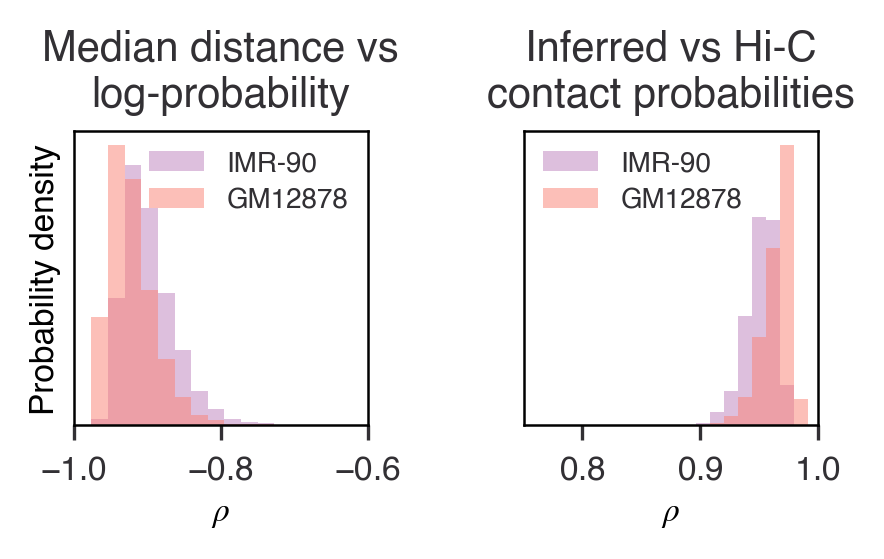

In [21]:
fig,axes = plt.subplots(ncols=2,nrows=1,layout='constrained',figsize=(3,1.75))


###########################
# Median dists vs log probabilities

####
# fetch data from the dictionaries
'''
data1 = []
for chrom,data_dict in results['IMR-90']['dist'].items():
    if chrom == 'X':
        continue
    data1+= [v for v in data_dict.values()]
data2 = []
for chrom,data_dict in results['GM12878']['dist'].items():
    if chrom == 'X':
        continue
    data2+= [v for v in data_dict.values()]

data1 = torch.tensor(data1)
data2 = torch.tensor(data2)
'''
data1 = b['corr_dist'][.5]
data2 = a['corr_dist'][.5]

####
# Plot
ax = axes[0]
#bins = torch.arange(-1,-.599,.4/15)
bins = torch.arange(-0.9756, -0.4105+.0003, (-0.4105+0.9756)/25)
plot_hist(
    data1 = data1,
    data2 = data2,
    tag1 = 'IMR-90',
    tag2 = 'GM12878',
    nbins = 13,#13,
    fig = fig,
    ax = ax,
    alpha = 0.5,
    bins = bins
    #bins = None
)

####
# Additional formatting
ax.set_ylabel('Probability density')
ax.set_xlabel('$\\rho$')
ax.set_yticks([])
ax.set_xlim([-1,-.6])
ax.set_xticks([-1,-.8,-.6])
ax.set_title('Median distance vs\nlog-probability')
ax.legend(frameon=False,fontsize='small')
xl = ax.get_xlim()
yl = ax.get_ylim()
ax.set_aspect( (xl[1]-xl[0]) / (yl[1]-yl[0]) )

###########################
# ChromoGen vs experimental contact probabilities

####
# fetch data from the dictionaries
'''
data1 = []
for chrom,data_dict in results['IMR-90']['hic'].items():
    if chrom == 'X':
        continue
    data1+= [v for v in data_dict.values()]
data2 = []
for chrom,data_dict in results['GM12878']['hic'].items():
    if chrom == 'X':
        continue
    data2+= [v for v in data_dict.values()]

data1 = torch.tensor(data1)
data2 = torch.tensor(data2)
'''
data1 = b['corr_prob'][.5]
data2 = a['corr_prob'][.5]

####
# Plot
ax = axes[1]
bins = torch.arange(.695, .993, (.992-.695)/25).numpy() 
bins = [0.6945, 0.7064, 0.7183, 0.7302, 0.7421, 0.7540, 0.7659, 0.7778, 0.7897,
         0.8016, 0.8135, 0.8254, 0.8373, 0.8492, 0.8611, 0.8730, 0.8849, 0.8968,
         0.9087, 0.9206, 0.9325, 0.9444, 0.9563, 0.9682, 0.9801, 0.9920]
plot_hist(
    data1 = data1,
    data2 = data2,
    tag1 = 'IMR-90',
    tag2 = 'GM12878',
    nbins = 13,#25,
    fig = fig,
    ax = ax,
    alpha = 0.5,
    bins = bins
)

####
# Additional formatting
ax.set_xlabel('$\\rho$')
ax.set_yticks([])
ax.set_xlim([.75,1])
ax.set_xticks([.8,.9,1.])
ax.set_title('Inferred vs Hi-C\ncontact probabilities')
ax.legend(frameon=False,fontsize='small')
xl = ax.get_xlim()
yl = ax.get_ylim()
ax.set_aspect( (xl[1]-xl[0]) / (yl[1]-yl[0]) )

#fig.savefig(pdf_dir/'part_c.pdf',transparent=True)    

In [17]:
b['corr_dist'][.5].shape

torch.Size([2516])

In [ ]:
asdf

In [ ]:
data1 = []
for chrom,data_dict in results['IMR-90']['dist'].items():
    if chrom == 'X':
        continue
    data1+= [v for v in data_dict.values()]
data2 = []
for chrom,data_dict in results['GM12878']['dist'].items():
    if chrom == 'X':
        continue
    data2+= [v for v in data_dict.values()]

data1 = torch.tensor(data1)
data2 = torch.tensor(data2)

In [ ]:
data_files = [
    f'../Figure_3/calc_results/{x}.pt'
    for x in ['dist_v_dist','dist_v_prob_cgen','dist_v_prob_dipc','prob_v_prob_cgen','prob_v_prob_dipc']
]

if True:#all(f.exists() for f in data_files):
    
    dist_v_dist = torch.load(data_files[0])
    dist_v_prob_cgen = torch.load(data_files[1])
    dist_v_prob_dipc = torch.load(data_files[2])
    prob_v_prob_cgen = torch.load(data_files[3])
    prob_v_prob_dipc = torch.load(data_files[4])

In [ ]:
min(
    dist_v_prob_cgen[dist_v_prob_cgen.isfinite()].min(), 
    dist_v_prob_dipc[dist_v_prob_dipc.isfinite()].min(),
    data1[data1.isfinite()].min(),
    data2[data2.isfinite()].min()
    
), max(
    dist_v_prob_cgen[dist_v_prob_cgen.isfinite()].max(), 
    dist_v_prob_dipc[dist_v_prob_dipc.isfinite()].max(),
    data1[data1.isfinite()].max(),
    data2[data2.isfinite()].max()
)

#### Check files...

In [ ]:
from pathlib import Path
import torch
from tqdm.auto import tqdm

In [9]:
d1 = Path('../../downloaded_data/conformations/ChromoGen/genome_wide/GM12878/')
d2 = Path('../../downloaded_data/conformations/ChromoGen/genome_wide/IMR90/')

files = list(d1.rglob('*0.0.pt'))

for f in tqdm(files):
    fn = f'{f.parent.name}/{f.name}'
    fn1 = fn.replace('1.0_rescaled_phi_0.0','5.0_rescaled_phi_8.0')

    a = torch.load(d1/fn).nan_to_num_(-69)
    b = torch.load(d1/fn1).nan_to_num_(-69)
    c = torch.load(d2/fn).nan_to_num_(-69)
    d = torch.load(d2/fn1).nan_to_num_(-69)

    if torch.equal(a,b):
        print(f'a & b, {fn}')
    if torch.equal(a,c):
        print(f'a & c, {fn}')
    if torch.equal(a,d):
        print(f'a & d, {fn}')
    if torch.equal(b,c):
        print(f'b & c, {fn}')
    if torch.equal(b,d):
        print(f'b & d, {fn}')
    if torch.equal(c,d):
        print(f'c & d, {fn}')

    

  0%|          | 0/2658 [00:00<?, ?it/s]